In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ray

from mdps.cliff import ContextualCliff
from utils.distributions import ConstantDistribution, ParticleDistribution

In [2]:
% load_ext autoreload
% autoreload 2

# Contextual Cartpole

This notebook studies using particle filtering to estimate the context parameters of a standard cartpole environment.

# Set target

We first create a target config, $c$. This will be the $MDP(c)$ the expert uses to generate the observational data.

In [3]:
# true (expert) context: (left_bound, right_bound, pow, step_size, noise, drift) =
#                       [-1, 1, 2, 0.1, 0.1, 0.05]
c = {'context_distribution':
         ConstantDistribution(dim=6,
                              constant_vector=np.array([-1, 1, 2, 0.1, 0.1, 0.05]))}

Train an expert that masters this context.

In [4]:
from ray.rllib.agents import ppo

ray.shutdown()
ray.init()
expert = ppo.PPOTrainer(env=ContextualCliff, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(30):
    res = expert.train()
    print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-02-08 00:27:15,353	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8266
2022-02-08 00:27:16,619	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-02-08 00:27:16,619	INFO trainer.py:745 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-02-08 00:27:18,073	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 10.173038202102273
1 10.867467062668723
2 9.96000526629742
3 10.860962304248046
4 13.552230640093748
5 16.146476982373002
6 18.016458659928205
7 20.024035796062797
8 21.432168951029183
9 24.085491516756257
10 27.16685174519891
11 28.828614479237856
12 29.116945085404765
13 27.649651493216037
14 28.71209951239021
15 31.458953223218582
16 31.749012505268514
17 32.636611681118964
18 33.41332239037941
19 33.879314001624095
20 35.233545894757185
21 36.873323612497956
22 37.05829715304408
23 36.01901533722185
24 34.306974062862054
25 34.64761852614703
26 34.54416304955184
27 35.67283212049815
28 34.98128271263718
29 35.37876825553982


In [5]:
# collect expert rollout
env = ContextualCliff(config=c)
done = False
obs = env.reset()
# run until episode ends
gt_obs_arr = None
while not done:
    action = expert.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    if gt_obs_arr is None:
        gt_obs_arr = obs
    else:
        gt_obs_arr = np.vstack((gt_obs_arr, obs))

In [6]:
gt_obs_arr.shape

(100, 7)

## Exact context

We first train a RL solver only on the correct context for particle filtering. We have already done this so we can directly use the expert solver.

In [29]:
# true (expert) context: (left_bound, right_bound, pow, step_size, noise, drift) =
#                       [-1, 1, 2, 0.1, 0.1, 0.05]

N = 10000
T = 100
left_bound = np.random.normal(loc=-1, scale=0.01, size=(N,))
right_bound = np.random.normal(loc=1, scale=0.01, size=(N,))
pow = np.ones((N,)) * 2
step_size = np.ones((N,)) * 0.1
noise = np.ones((N,)) * 0.1
drift = np.random.normal(loc=0.03, scale=0.02, size=(N,))

context_particles = np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T
context_particles = np.abs(context_particles)
context_distribution = ParticleDistribution(dim=6, particles=context_particles, n_particles=N)

In [30]:
solver = expert
state_arr = np.zeros((N,))
action_arr = np.zeros((N,))
context_history = []
for t in range(T):
    # we only use the first 5 steps of the cartpole steps to reduce effect of different episode lengths
    qs = np.zeros((N,))
    for n in range(N):
        context = context_distribution.particles[n]
        if context[4] < 0:
            qs[n] = 0
            state_arr[n] = np.copy(env.mdp.x)
            continue
        c_local = {'context_distribution':
                       ConstantDistribution(dim=6,
                                            constant_vector=context)}
        env = ContextualCliff(config=c_local)
        done = False
        obs = env.reset()
        if t > 0:
            env.mdp.x = state_arr[n]
            obs = np.concatenate((np.array([env.mdp.x]), context), axis=0).flatten()
        action = solver.compute_single_action(obs)
        obs, reward, done, info = env.step(action)
        # estimate likelihood if r >= 1
        if t >= 1:
            q = env.likelihood(gt_obs_arr[t - 1], action_arr[n], obs)
            qs[n] = q
        state_arr[n] = np.copy(env.mdp.x)
        action_arr[n] = action
    if t >= 1:
        qs = qs / qs.sum()
        resample_index = context_distribution.resample_particles_from_probability(p=qs)
        ptemp = context_distribution.particles
        pnoise = np.random.normal(loc=0, scale=ptemp.std(axis=0), size=ptemp.shape) * 0.05
        context_distribution.particles += pnoise
        state_arr = state_arr[resample_index]
        action_arr = action_arr[resample_index]
    print(t, context_distribution.particles[:, -1].mean())
    context_history += [context_distribution.particles.copy()]

0 0.031248786384409994
1 0.04321198141103502
2 0.04647051357027527
3 0.046638595890699366
4 0.04637528821754171
5 0.046490144244903636
6 0.04677113274102739
7 0.04721992618271268
8 0.047617725686675876
9 0.04769944659407966
10 0.047522821727505445
11 0.04743130185816219
12 0.0471879868913869
13 0.04744138207570747
14 0.047531403112474474
15 0.04718100609475981
16 0.047025944461945565
17 0.04668117807281931
18 0.04645660276886907
19 0.04651225727415135
20 0.046248894230906765
21 0.046326096872700305
22 0.04621923663096069
23 0.04624256192594662
24 0.04636628955927033
25 0.046926463893646665
26 0.04739778562646074
27 0.04745208521129903
28 0.04676053008071133
29 0.0464962189192335
30 0.046302903068256525
31 0.04620894969309065
32 0.04545178919387828
33 0.04551886099096324
34 0.04534259757286984
35 0.04536546331580037
36 0.04516650517793181
37 0.04499894025933572
38 0.044695278070102186
39 0.04433336310066219
40 0.04458640254893128
41 0.04469998510972713
42 0.043958074896120074
43 0.04375

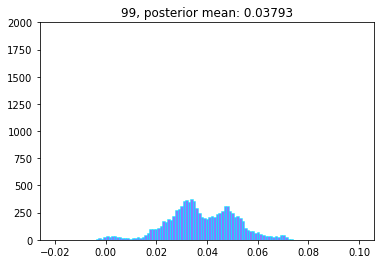

In [31]:
from matplotlib import animation

HIST_BINS = np.linspace(-0.02, 0.10, 120)


def prepare_animation(bar_container_):
    def animate(frame_number, data=context_history):
        # simulate new data coming in
        x = data[frame_number][:, -1]
        n, _ = np.histogram(x, HIST_BINS)
        plt.title(f'{frame_number}, posterior mean: {round(x.mean(), 5)}')
        for count, rect in zip(n, bar_container_.patches):
            rect.set_height(count)
        return bar_container_.patches

    return animate


fig, ax = plt.subplots()
_, _, bar_container = ax.hist(context_history[0][:, -1], HIST_BINS, lw=1,
                              ec="cyan", fc="blue", alpha=0.5)
ax.set_ylim(top=2000)  # set safe limit to ensure that all data is visible.

ani = animation.FuncAnimation(fig, prepare_animation(bar_container), len(context_history),
                              repeat=True, blit=False, interval=100, repeat_delay=500)
ani.save('small.mp4', dpi=300)
plt.show()

# Mis-specified context

We also see what happens if we train a solver only on an MDP $MDP(c_{miss})$, where $c_{miss}$ is a mis-specified context.

In [35]:
# We try a short cartpole on a planet with g=5.0. We also slightly reduce noise to 0.1.
c_mis = {'context_distribution':
             ConstantDistribution(dim=5,
                                  constant_vector=np.array([5, 0.5, 0.1, 0.5, 0.1, 1.]))}

ray.shutdown()
ray.init()
mis_solver = ppo.PPOTrainer(env=ContextualCliff, config={
    "env_config": c_mis,
    "framework": "torch",  # config to pass to env class
})

for eps in range(30):
    res = mis_solver.train()
    print(eps, res['episode_reward_mean'])

2022-02-07 13:48:02,099	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2022-02-07 13:48:04,570	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 16.520661157024794
1 29.116788321167885
2 46.22
3 68.62
4 90.35
5 115.09
6 130.48
7 151.13
8 172.98
9 187.48
10 204.04
11 216.97
12 243.83
13 262.72
14 293.09
15 312.45
16 350.85
17 376.13
18 390.21
19 418.78
20 473.69
21 486.92
22 525.33
23 525.33
24 551.49
25 649.67
26 688.52
27 688.52
28 718.98
29 718.98
